In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from tqdm import tqdm
import matplotlib.cm as cm

font = {'size'   : 12}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# for reproducibility
np.random.seed(0) 

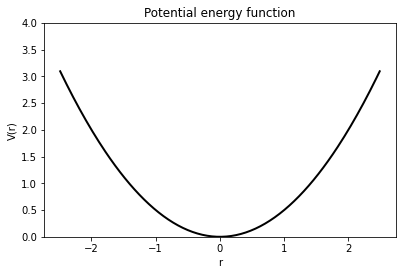

In [7]:
# System parameters
kB           = 0.008314463           # kJ mol-1 K
T            = 300                   # K
beta         = 1 / kB / T            # kJ-1 mol
M            = 1                     # amu

# Potential energy function kJ mol-1
r     = symbols('r')
V     = 0.5*r**2 #( r**2 - 1 )**2  
der_V = V.diff(r)

# Convert the potential and its derivative in numpy
V     = lambdify((r), V, modules=['numpy'])
der_V = lambdify((r), der_V, modules=['numpy'])

# 1D grid for position axis
rmin     = - 2.5
rmax     = - rmin
rbins    = 200
redges   = np.linspace(rmin, rmax, rbins)
dr       = redges[1] - redges[0]
rcenters = redges + 0.5* dr
rcenters = np.delete(rcenters, -1)
rbins    = len(rcenters)

# 1D grid for momentum axis
pmin     = - 6
pmax     = - pmin
pbins    = 200
pedges   = np.linspace(pmin, pmax, pbins)
dp       = pedges[1] - pedges[0]
pcenters = pedges + 0.5 * dp
pcenters = np.delete(pcenters, -1)
pbins    = len(pcenters)

# 2D grid for 2D histograms
grid     = np.meshgrid(rcenters, pcenters)
rgrid    = grid[0]
pgrid    = grid[1]



fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 10*in2cm))  

ax1.plot(rcenters, V(rcenters), 'k', linewidth=2)
ax1.set_title('Potential energy function')
ax1.set_xlabel('r')
ax1.set_ylabel('V(r)')
ax1.set_ylim((0, 4));

### Hamiltonian dynamics

Consider a particle with mass $M>0$, momentum $p\in \Gamma_p \subset \mathbb{R}$ and position $r\in \Gamma_r \subset \mathbb{R}$, moving in a potential energy function $V(r):\Gamma_r \rightarrow \mathbb{R}$.
The hamiltonian function of the system is

\begin{equation}
H = \frac{p^2}{2M} + V(r) \, ,
\end{equation}

and the equations of motion are written as

\begin{equation}
\begin{cases}
\dot{r} &= \frac{p(t)}{M} \\
\dot{p} &= F(t) = -\nabla_r V(r(t))\\
\end{cases} \, .
\end{equation}

In the following example, we consider the potential of the harmonic oscillator

$$
V(r) = \frac{1}{2}r^2 \, .
$$


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59999/59999 [00:00<00:00, 364965.14it/s]


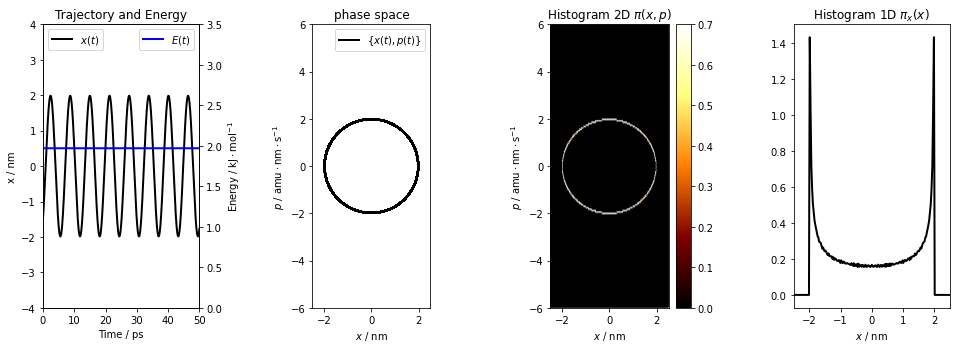

In [16]:
# Number of timesteps
Nsteps = 60000

# Integration timestep
dt = 0.02

# Array where to store positions
r = np.zeros((Nsteps))

# Initial position
r0   = -1.5
r[0] = r0

# Array where to store momenta
p = np.zeros((Nsteps))

# Randomly draw initial momentum from Maxwell-Boltzmann distribution
p0   = 1.3
p[0] = p0

# Array where to store energy
E = np.zeros((Nsteps))

# Initial energy
E[0]  =  p[0] ** 2 / ( 2 * M ) + V(r[0]) 


# Velocity Verlet integrator
for k in tqdm(range(Nsteps-1)):
    
    # force
    F       = - der_V(r[k])

    # Evolve position
    r[k+1]  =  r[k]   + p[k] / M * dt + 0.5 * F / M * dt ** 2

    # force on particle at time t_k + 1
    F1      = - der_V(r[k+1])

    # Evolve momentum
    p[k+1]  =  p[k]   + 0.5 * ( F + F1 ) * dt
        
    # Total energy
    E[k+1]  =  p[k+1] ** 2 / ( 2 * M ) + V(r[k+1])     
    
# Build histogram of position and momenta
hist2  =  np.histogram2d(r, p, bins=[redges, pedges], density = True )[0]

# Project the histogram along the momenta axis
hist1  =  np.sum(hist2 * dp, axis=1)

#np.linalg.norm(hist, ord=1, axis=1, keepdims=True)
#hist  = hist / row_norms_l1

############################################## F I G U R E

# Time intervals
tvalues = np.linspace(0, Nsteps-1,Nsteps) * dt

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(32*in2cm, 10*in2cm))  
ax1r = ax1.twinx()
ax1.plot(tvalues[0:10000:1], r[0:10000:1],'k-', linewidth = 2, label = r'$x(t)$')
ax1.set_xlabel('Time / ps')
ax1.set_ylabel('x / nm')
ax1.set_title('Trajectory and Energy')
ax1.set_xlim((0,50))
ax1.set_ylim((-4,4))
ax1r.plot(tvalues, E,'b-', linewidth = 2, label = r'$E(t)$')
ax1r.set_ylabel(r'Energy / $\mathrm{kJ\cdot mol^{-1}}$')
ax1r.set_ylim((0, 3.5))

ax2.plot(r, p, 'k-', linewidth = 2, label = r'$\lbrace x(t), p(t)\rbrace$')
ax2.set_xlabel(r'$x$ / nm')
ax2.set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax2.set_title('phase space')
ax2.set_xlim((rmin, rmax))
ax2.set_ylim((pmin, pmax))
ax2.set_aspect('equal')

pos = ax3.pcolormesh(rgrid, pgrid, hist2.T,  cmap = cm.afmhot, shading='gouraud', vmin = 0, vmax = 0.7)
ax3.set_title(r'Histogram 2D $\pi(x,p)$')
ax3.set_xlabel(r'$x$ / nm')
ax3.set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax3.set_xlim((rmin, rmax))
ax3.set_ylim((pmin, pmax))
ax3.set_aspect('equal')
fig.colorbar(pos, ax=ax3)

ax4.plot(rcenters, hist1, 'k-', linewidth = 2)
ax4.set_xlabel(r'$x$ / nm')
ax4.set_title(r'Histogram 1D $\pi_x(x)$')
ax4.set_xlim((rmin, rmax))

ax1.legend(loc='upper left')
ax1r.legend(loc='upper right')
ax2.legend(loc='upper right')



plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.6, hspace=0);
#fig.savefig('fig.png', format='png', dpi=900, bbox_inches='tight')